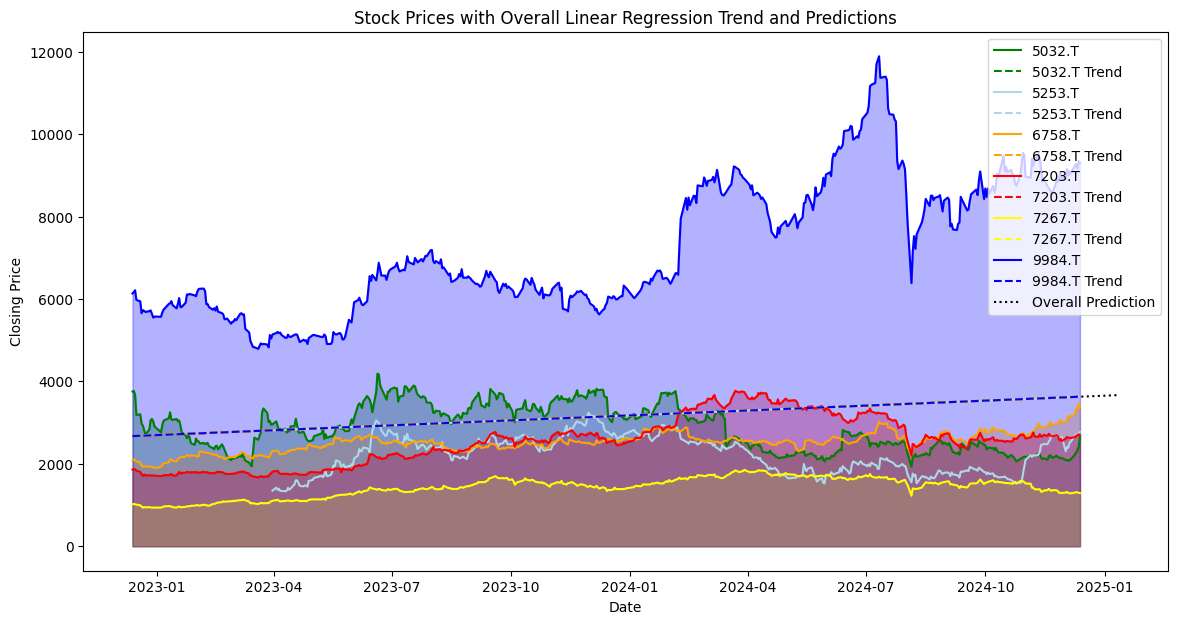

In [4]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from datetime import datetime

# Define the stock tickers and their start dates
# Stocks from AnyColor, Hololive, Sony, Toyota, Honda, and Softbank
tickers = {
    "5032.T": "2022-06-10",
    "5253.T": "2023-03-31",
    "6758.T": "2022-06-10",
    "7203.T": "2022-06-10",
    "7267.T": "2022-06-10",
    "9984.T": "2022-06-10"
}

# Fetch stock data
def fetch_data(ticker, start_date):
    stock = yf.Ticker(ticker)
    data = stock.history(period="2y")
    data = data[data.index >= start_date]
    return data

data_dict = {ticker: fetch_data(ticker, start_date) for ticker, start_date in tickers.items()}

# Function to prepare the data for ML
def prepare_data(data):
    data['Date'] = data.index
    data['Date'] = data['Date'].map(lambda x: x.toordinal())
    X = data['Date'].values.reshape(-1, 1)
    y = data['Close'].values
    return X, y

# Prepare data for all stocks and merge into a single dataset
combined_X = np.array([])
combined_y = np.array([])

for ticker, data in data_dict.items():
    X, y = prepare_data(data)
    if combined_X.size == 0:
        combined_X = X
        combined_y = y
    else:
        combined_X = np.vstack((combined_X, X))
        combined_y = np.concatenate((combined_y, y))

# Train the overall linear regression model
overall_model = LinearRegression()
overall_model.fit(combined_X, combined_y)

# Predict future prices
latest_date = max([data.index[-1] for data in data_dict.values()])
future_dates = np.arange(latest_date.toordinal() + 1, latest_date.toordinal() + 31).reshape(-1, 1)  # Predict for the next 30 days
future_pred = overall_model.predict(future_dates)
future_dates = [latest_date + np.timedelta64(i, 'D') for i in range(1, 31)]

# Plot the data
plt.figure(figsize=(14, 7))

colors = {
    "5032.T": "green",
    "5253.T": "lightblue",
    "6758.T": "orange",
    "7203.T": "red",
    "7267.T": "yellow",
    "9984.T": "blue"
}

for ticker, data in data_dict.items():
    color = colors[ticker]
    # Plot stock data
    plt.plot(data.index, data['Close'], label=ticker, color=color)
    plt.fill_between(data.index, data['Close'], color=color, alpha=0.3)
    # Plot the individual linear regression line
    X, _ = prepare_data(data)
    plt.plot(data.index, overall_model.predict(X), color=color, linestyle='--', label=f'{ticker} Trend')

# Plot the overall trend line
plt.plot(future_dates, future_pred, color='black', linestyle=':', label='Overall Prediction')

# Add title and labels
plt.title('Stock Prices with Overall Linear Regression Trend and Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')

# Show legend
plt.legend()

# Display the plot
plt.show()
